In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *
import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/base_abt_split.h5')
X_train, X_test, y_train, y_test = store['X_train'], store['X_test'], store['y_train'], store['y_test']
store.close()

# Drop msno from the dataset
X_train.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1)
X_test.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1)

print("Train Shape:", X_train.shape, y_train.shape)
print("Train Shape:", X_test.shape, y_test.shape)
X_train.head()

Train Shape: (600803, 13) (600803,)
Train Shape: (257487, 13) (257487,)


,city,bd,registered_via,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,is_auto_renew_mode,transaction_date_max,cancel_times
703741,4,32,3,22,33,1,30,21.82,108.36,2384.00,True,20170228,0
228194,13,33,3,19,39,1,30,28.58,141.16,2682.00,True,20170131,0
735733,15,22,3,17,40,3,30,30.00,158.12,2688.00,True,20170210,4
774256,1,0,7,26,41,1,30,28.85,143.27,3725.00,True,20170205,0
282188,1,0,7,27,41,1,30,28.89,132.00,3564.00,True,20170216,1


In [10]:
RANDOM_STATE = 42 
CV_ITER = None
SCORING_METRIC = autosklearn.metrics.recall
BASE_NAME = "askbasic_" + str(CV_ITER) + "cv_" + str(SCORING_METRIC)
N_JOBS = 8

## Set the list of the categorical columns in the dataset
cat_col = ['city', 'registered_via', 'payment_method_id_mode']

df_cols = X_train.columns
feat_types =  ['Categorical' if col in cat_col else 'Numerical' for col in df_cols]

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]   
classifiers = [
        ('ASKLEARN_.25_' + BASE_NAME, 
         autosklearn.classification.AutoSklearnClassifier(
                time_left_for_this_task=int(3600*.25), 
                n_jobs=N_JOBS,
                include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
                                    "liblinear_svc", "xgradient_boosting"], 
                exclude_estimators=None,
                include_preprocessors=["no_preprocessing", ], 
                exclude_preprocessors=None,
                ml_memory_limit = 3072*5), {}, 
         SCORING_METRIC),
        ('ASKLEARN_.5_' + BASE_NAME, 
         autosklearn.classification.AutoSklearnClassifier(
                time_left_for_this_task=int(3600*.5), 
                n_jobs=N_JOBS,
                include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
                                    "liblinear_svc", "xgradient_boosting"], 
                exclude_estimators=None,
                include_preprocessors=["no_preprocessing", ], 
                exclude_preprocessors=None,
                ml_memory_limit = 3072*5), {}, 
         SCORING_METRIC),
#         ('ASKLEARN_1_' + BASE_NAME, 
#          autosklearn.classification.AutoSklearnClassifier(
#                 time_left_for_this_task=int(3600*1), 
#                 n_jobs=N_JOBS,
#                 include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
#                                     "liblinear_svc", "xgradient_boosting"], 
#                 exclude_estimators=None,
#                 include_preprocessors=["no_preprocessing", ], 
#                 exclude_preprocessors=None,
#                 ml_memory_limit = 3072*5), {}, 
#          SCORING_METRIC),
#         ('ASKLEARN_2_' + BASE_NAME, 
#          autosklearn.classification.AutoSklearnClassifier(
#                 time_left_for_this_task=int(3600*2), 
#                 n_jobs=N_JOBS,
#                 include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
#                                     "liblinear_svc", "xgradient_boosting"], 
#                 exclude_estimators=None,
#                 include_preprocessors=["no_preprocessing", ], 
#                 exclude_preprocessors=None,
#                 ml_memory_limit = 3072*4), {}, 
#          SCORING_METRIC),
#         ('ASKLEARN_6_' + BASE_NAME, 
#          autosklearn.classification.AutoSklearnClassifier(
#                 time_left_for_this_task=int(3600*6), 
#                 n_jobs=N_JOBS,
#                 include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
#                                     "liblinear_svc", "xgradient_boosting"], 
#                 exclude_estimators=None,
#                 include_preprocessors=["no_preprocessing", ], 
#                 exclude_preprocessors=None,
#                 ml_memory_limit = 3072*2), {}, 
#          SCORING_METRIC),
#         ('ASKLEARN_12_' + BASE_NAME, 
#          autosklearn.classification.AutoSklearnClassifier(
#                 time_left_for_this_task=int(3600*12), 
#                 n_jobs=N_JOBS,
#                 include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
#                                     "liblinear_svc", "xgradient_boosting"], 
#                 exclude_estimators=None,
#                 include_preprocessors=["no_preprocessing", ], 
#                 exclude_preprocessors=None,
#                 ml_memory_limit = 3072*2), {}, 
#          SCORING_METRIC)
]

In [8]:
all_metrics = pd.DataFrame()
all_results = list()

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 13) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 13) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
X_train:  (600803, 68) (600803, 1)
X_test:  (257487, 68) (257487, 1)


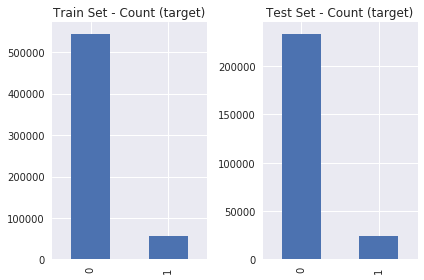

Training ASKLEARN_.25_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-07 09:58:56,812:EnsembleBuilder(1791095845):0dd3e4e45aa5507e5d58e2d0731a3935] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 09:58:57,038:EnsembleBuilder(1791095845):0dd3e4e45aa5507e5d58e2d0731a3935] No models better than random - using Dummy Score!


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 09:58:59,153:EnsembleBuilder(1791095845):0dd3e4e45aa5507e5d58e2d0731a3935] No models better than random - using Dummy Score!


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 09:59:01,268:EnsembleBuilder(1791095845):0dd3e4e45aa5507e5d58e2d0731a3935] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 09:59:03,289:EnsembleBuilder(1791095845):0dd3e4e45aa5507e5d58e2d0731a3935] No models better than random - using Dummy Score!


Process pynisher function call:
Process pynisher function call:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Process pynisher function call:
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/lockfile/linklockfile.py", line 31, in acquire
    os.link(self.unique_name, self.lock_file)
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/lockfile/linklockfile.py", line 31, in acquire
    os.link(self.unique_name, self.lock_file)
FileExistsError: [Errno 17] File exists: '/tmp/autosklearn_tmp_19167_4905/.auto-sklearn/Ubuntu-1804-bionic-64-minimal-60f9a740.192026819701174930601903' -> '/tmp/autosklearn_tmp_19167_4905/.auto-sklearn/datamanager.

[ERROR] [2019-08-07 09:59:05,254:root] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Process Process-1:
Process Process-2:
Process Process-6:
Process Process-7:
Process pynisher function call:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process pynisher function call:
  File "/home/anaconda/envs/

Traceback (most recent call last):
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "modules/shared_functions.py", line 137, in perform_experiment
    feat_defs = feat_defs
  File "modules/shared_functions.py", line 195, in train_model
    y_train)
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/estimators.py", line 664, in fit
    dataset_name=dataset_name,
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/estimators.py", line 399, in fit
    load_models=True,
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/anaconda/envs/py373

  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anaconda/envs/py373/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)


KeyboardInterrupt: 

  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,


In [11]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [13]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

Model Build Iteration 0


KeyboardInterrupt: 

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [12]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

Model Build Iteration 0
[ERROR] [2019-08-07 09:59:05,884:root] Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/anaconda/envs/py373/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "modules/shared_functions.py", line 123, in perform_experiment
    cat_col = cat_col)
  File "modules/shared_functions.py", line 80, in prepare_train_test_data
    print("PRE-SAMPLING:", X_train.shape, y_train.shape, Counter(y_train))
  File "/home/anaconda/envs/py373/lib/python3.7/collections/__init__.py", line 566, in __init__
    self.update(*args, **kwds)
  File "/home/anaconda/envs/py373/lib/python3.7/collections/__init__.py", line 653, in update
    _count_elements(self, iterable)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call la

KeyboardInterrupt: 

In [ ]:
all_results

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
%%time
start = time.time()

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,12,13], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'bd', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times']

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics.sort_values('aucroc', ascending=False).head(15)

In [ ]:
#store(all_results, 'Asklearn_Default_Undersample.pickle')

# Write (overwrite) the file to store the experiment results
with open('Asklearn_Default_Undersample.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    print("Writing results to", f.name)
    pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)